In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 2433 images belonging to 2 classes.
Found 608 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Found 1521 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9622

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 348s 4s/step - loss: 0.0924 - accuracy: 0.9622 - val_loss: 0.0255 - val_accuracy: 0.9961
Epoch 2/20
77/77 [==============================] - 25s 325ms/step - loss: 0.0147 - accuracy: 0.9992 - val_loss: 0.0229 - val_accuracy: 0.9934
Epoch 3/20
77/77 [==============================] - 27s 334ms/step - loss: 0.0070 - accuracy: 0.9996 - val_loss: 0.0112 - val_accuracy: 0.9974
Epoch 4/20
77/77 [==============================] - 25s 323ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9974
Epoch 5/20
77/77 [==============================] - 25s 316ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9974
Epoch 6/20
77/77 [==============================] - 24s 310ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9967
Epoch 7/20
77/77 [==============================] - 25s 325ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0060 - val_accuracy: 0.9974
Epoch 8/20
7

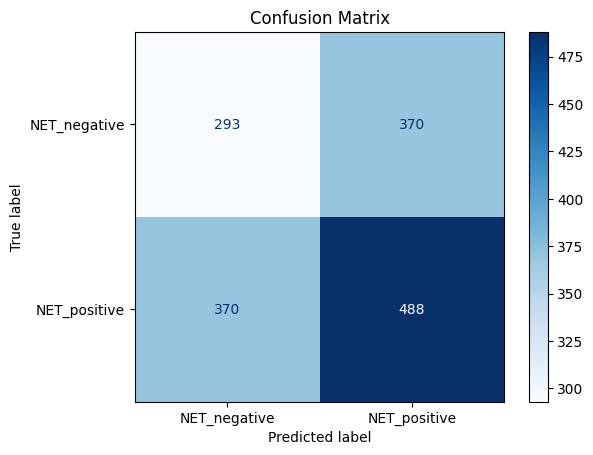

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/data/vgg16_nets_model_2.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/modified_dataset_subimaging'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## F1 Score

GPU is available
Found 2433 images belonging to 2 classes.
Found 608 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Found 1521 images belonging to 2 classes.
Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9367 - f1_score: 0.9367 - auc: 0.9879

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 26s 298ms/step - loss: 0.1414 - accuracy: 0.9367 - f1_score: 0.9367 - auc: 0.9879 - val_loss: 0.0351 - val_accuracy: 0.9895 - val_f1_score: 0.9895 - val_auc: 0.9996
Epoch 2/20
77/77 [==============================] - 24s 315ms/step - loss: 0.0175 - accuracy: 0.9979 - f1_score: 0.9979 - auc: 1.0000 - val_loss: 0.0260 - val_accuracy: 0.9934 - val_f1_score: 0.9934 - val_auc: 0.9998
Epoch 3/20
77/77 [==============================] - 27s 346ms/step - loss: 0.0094 - accuracy: 0.9996 - f1_score: 0.9996 - auc: 1.0000 - val_loss: 0.0138 - val_accuracy: 0.9974 - val_f1_score: 0.9974 - val_auc: 1.0000
Epoch 4/20
77/77 [==============================] - 27s 351ms/step - loss: 0.0064 - accuracy: 0.9996 - f1_score: 0.9996 - auc: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9980 - val_f1_score: 0.9980 - val_auc: 1.0000
Epoch 5/20
77/77 [==============================] - 26s 337ms/step - loss: 0.0045 - accuracy: 0.9996 - f1_score: 0.9996 - auc: 1.0000 - val_los

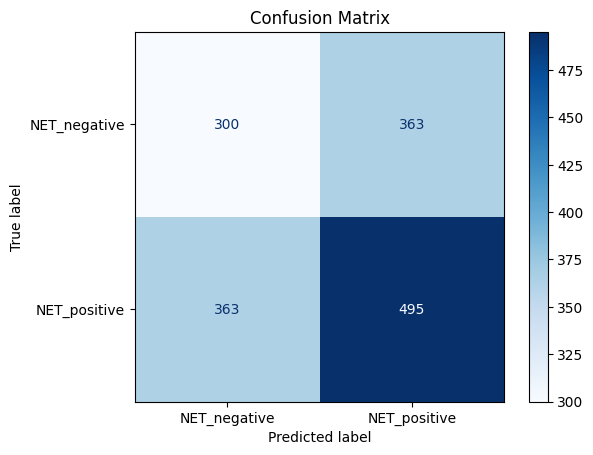

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.utils.class_weight import compute_class_weight

# Check GPU availability
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available")
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
else:
    print("GPU is not available")

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/data/vgg16_nets_model_3.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/modified_dataset_subimaging'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Define custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Compile the model using legacy Adam optimizer and custom metrics
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(), tf.keras.metrics.AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'F1Score': F1Score})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Recall

Found 2433 images belonging to 2 classes.
Found 608 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Found 1521 images belonging to 2 classes.
58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9486 - recall: 0.9486 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 1305s 17s/step - loss: 0.1124 - accuracy: 0.9486 - recall: 0.9486 - val_loss: 0.0252 - val_accuracy: 0.9947 - val_recall: 0.9947
Epoch 2/20
77/77 [==============================] - 27s 349ms/step - loss: 0.0134 - accuracy: 0.9988 - recall: 0.9988 - val_loss: 0.0159 - val_accuracy: 0.9967 - val_recall: 0.9967
Epoch 3/20
77/77 [==============================] - 23s 290ms/step - loss: 0.0075 - accuracy: 0.9992 - recall: 0.9992 - val_loss: 0.0183 - val_accuracy: 0.9947 - val_recall: 0.9947
Epoch 4/20
77/77 [==============================] - 26s 338ms/step - loss: 0.0054 - accuracy: 0.9996 - recall: 0.9996 - val_loss: 0.0091 - val_accuracy: 0.9974 - val_recall: 0.9974
Epoch 5/20
77/77 [==============================] - 21s 274ms/step - loss: 0.0033 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9967 - val_recall: 0.9967
Epoch 6/20
77/77 [==============================] - 22s 288ms/step - loss: 0.0026 - accuracy: 1.0000 - rec

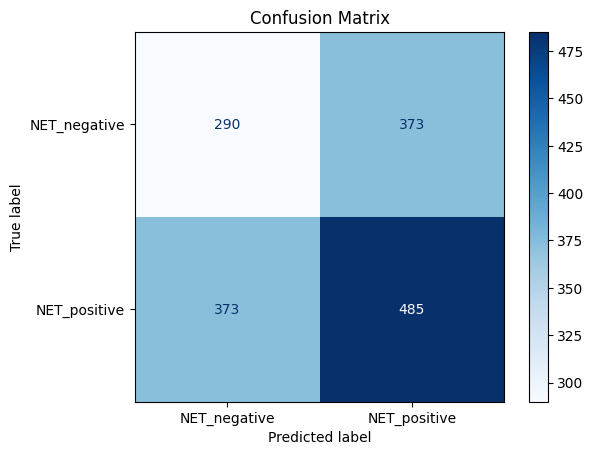

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/data/vgg16_nets_model_recall.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/modified_dataset_subimaging'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a focus on recall
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_recall', mode='max')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'recall': tf.keras.metrics.Recall(name='recall')})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Constants
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/data/vgg16_nets_model_recall.h5'  # Path to the trained model
class_labels = ['NET_negative', 'NET_positive', 'Artifact']  # Replace with your actual class labels

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'recall': tf.keras.metrics.Recall(name='recall')})

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

def predict_image(img_path, model, class_labels):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label, prediction

# Example usage
img_path = '/content/drive/MyDrive/Colab Notebooks/data/subimages_for_modeling 3/NET_positive_pma/20211111.lif_PMA 3.11.21NET488_MPO633_002.tif_sub_image_11.png'
predicted_label, prediction = predict_image(img_path, model, class_labels)

print(f'Predicted class: {predicted_label}')
print(f'Prediction probabilities: {prediction}')


1/1 [==============================] - 1s 729ms/step
Predicted class: NET_negative
Prediction probabilities: [[0.82161045 0.17838952]]


1/1 [==============================] - 0s 492ms/step


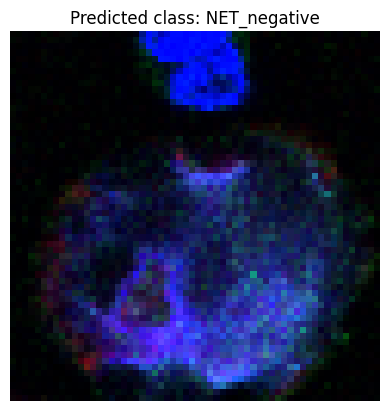

Predicted class: NET_negative
Prediction probabilities: [[0.85093963 0.1490604 ]]
1/1 [==============================] - 0s 386ms/step


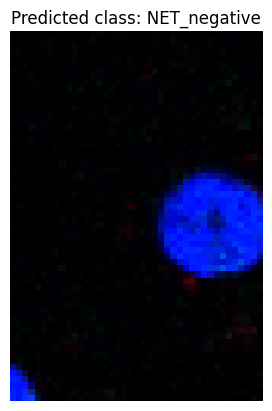

Predicted class: NET_negative
Prediction probabilities: [[9.994875e-01 5.124114e-04]]
1/1 [==============================] - 0s 371ms/step


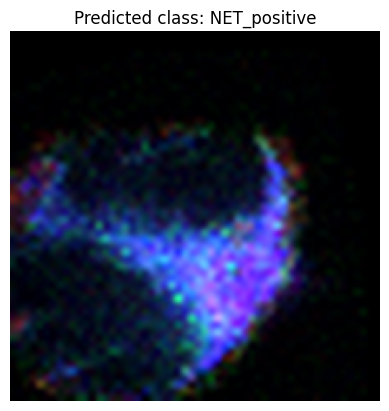

Predicted class: NET_positive
Prediction probabilities: [[8.014927e-09 1.000000e+00]]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Constants
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/data/vgg16_nets_model_3.h5'  # Path to the trained model
class_labels = ['NET_negative', 'NET_positive', 'Artifact']  # Replace with your actual class labels

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'recall': tf.keras.metrics.Recall(name='recall')})

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

def predict_image(img_path, model, class_labels):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label, prediction

def display_predictions(img_paths, model, class_labels):
    for img_path in img_paths:
        predicted_label, prediction = predict_image(img_path, model, class_labels)

        # Load and display the image
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_label}')
        plt.axis('off')
        plt.show()

        print(f'Predicted class: {predicted_label}')
        print(f'Prediction probabilities: {prediction}')

# Example usage
img_paths = [
    '/content/drive/MyDrive/Colab Notebooks/data/subimages_for_modeling 3/NET_positive_pma/20211111.lif_PMA 3.11.21NET488_MPO633_002.tif_sub_image_11.png',
    '/content/drive/MyDrive/Colab Notebooks/data/subimages_for_modeling 3/NET_negative/20211111.lif_PMA 3.11.21NET488_MPO633_002.tif_sub_image_62.png',
    '/content/drive/MyDrive/Colab Notebooks/data/modified_dataset_subimaging/NET_positive/aug_0_20211111.lif_PMA 3.11.21NET488_MPO633_002.tif_sub_image_16.png'
    # Add more image paths as needed
]

display_predictions(img_paths, model, class_labels)
